# Landsat LAI Example - Static

In [1]:
import pprint

import ee
from IPython.display import Image

import openet.lai.landsat

ee.Initialize()


In [2]:
viridis_palette = ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725']
ndvi_palette = ['EFE7E1', '003300']

image_size = 768


In [3]:
landsat_id = 'LC08_042034_20180705'  # Clear
# landsat_id = 'LC08_044033_20170716'  # pytest scene

landsat_img = ee.Image(f'LANDSAT/LC08/C02/T1_L2/{landsat_id}')
landsat_crs = landsat_img.select('SR_B3').projection().getInfo()['crs']


In [4]:
site_xy = [-120.105, 36.95]
# site_xy = [-120.10237, 36.946608]
dx = 0.02
dy = 0.01
# dx = 0.012
# dy = 0.006
study_geom = ee.Geometry.Rectangle(site_xy[0]-dx, site_xy[1]-dy, site_xy[0]+dx, site_xy[1]+dy)
study_region = study_geom.bounds(1, 'EPSG:4326')


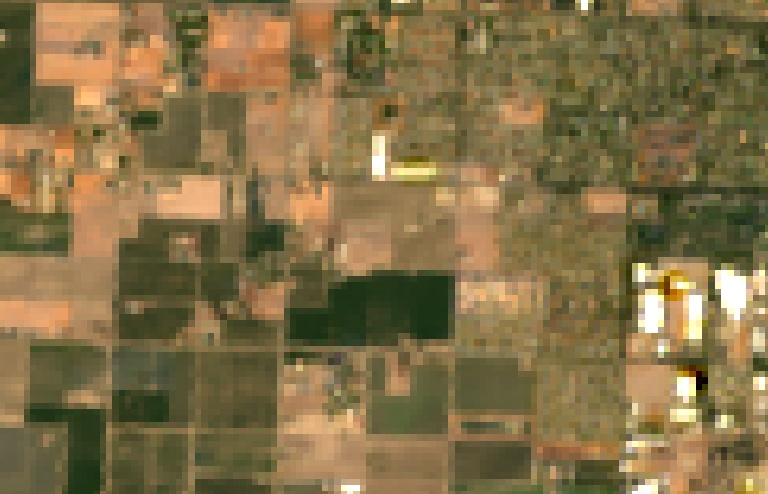

In [5]:
image_url = landsat_img.select([3, 2, 1]).multiply(0.0000275).add(-0.2)\
    .getThumbURL({'min': 0.0, 'max': 0.3, 'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')
# print(image_url)


## Prepare the Landsat image for computing LAI

This primarily consists of standardizing the band names.

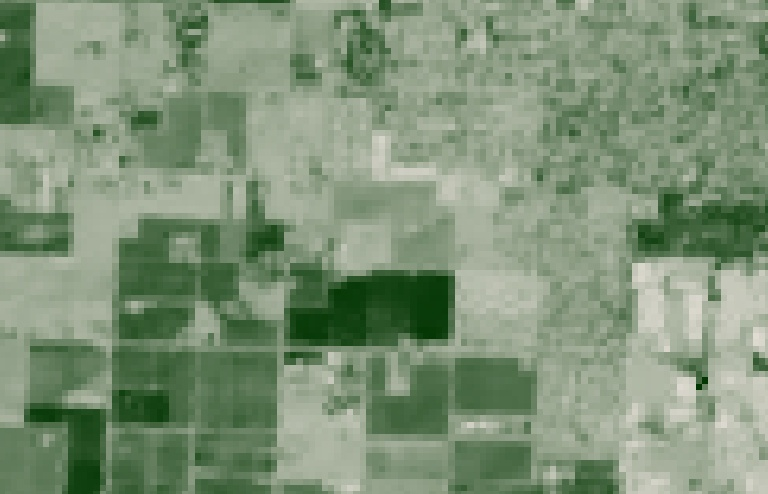

In [6]:
# "Prep" the Landsat image
# This same functionality is in the Landsat module/class
# Note, the reflectance values are intentionally being scaled by 10000 to
#   match the original Collection 1 SR scaling used in the training
input_bands = ee.Dictionary({
    'LANDSAT_5': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL'],
    'LANDSAT_7': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL'],
    'LANDSAT_8': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'],
    'LANDSAT_9': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'],
})
output_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'qa']
spacecraft_id = ee.String(landsat_img.get('SPACECRAFT_ID'))
prep_img = (
    landsat_img.select(input_bands.get(spacecraft_id), output_bands)
    .multiply([0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.0000275, 1])
    .add([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, 0])
    .divide([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 1])
    .set({
        'system:index': landsat_img.get('system:index'),
        'system:time_start': landsat_img.get('system:time_start'),
        'system:id': landsat_img.get('system:id'), 
        'SPACECRAFT_ID': spacecraft_id,
        'SOLAR_AZIMUTH_ANGLE': ee.Number(landsat_img.get('SUN_AZIMUTH')),
        'SOLAR_ZENITH_ANGLE': ee.Number(landsat_img.get('SUN_ELEVATION'))
            .multiply(-1).add(90),
    })
)

image_url = prep_img.normalizedDifference(['nir', 'red']).select(['nd'], ['ndvi']) \
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette,
                  'dimensions':image_size, 'region': study_region})
Image(url=image_url, embed=True, format='png')


In [7]:
# # "Prep" the Landsat image using the Landsat class
# landsat_obj = openet.lai.Landsat(landsat_id)

# image_url = landsat_obj.input_img.normalizedDifference(['nir', 'red']).select(['nd'], ['ndvi']) \
#     .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette,
#                   'dimensions':image_size, 'region': study_region})
# Image(url=image_url, embed=True, format='png')

## Run the Landsat LAI algorithm

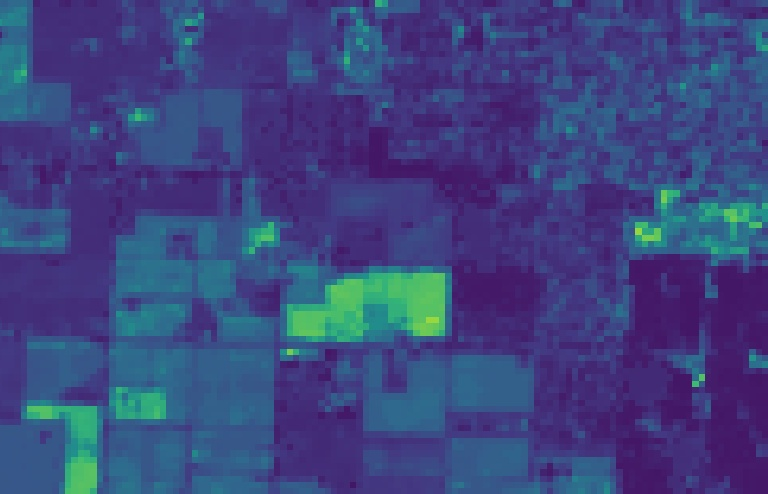

In [8]:
# Generate the LAI image
output_img = openet.lai.model.get_lai_image(
    prep_img, sensor=landsat_id.split('_')[0], nonveg=True,
)

image_url = (
    output_img.select(['LAI'])
    .reproject(crs=landsat_crs, scale=30)
    .getThumbURL({'min': 0, 'max': 4, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
)
Image(url=image_url, embed=True, format='png')


## Check the QA bands

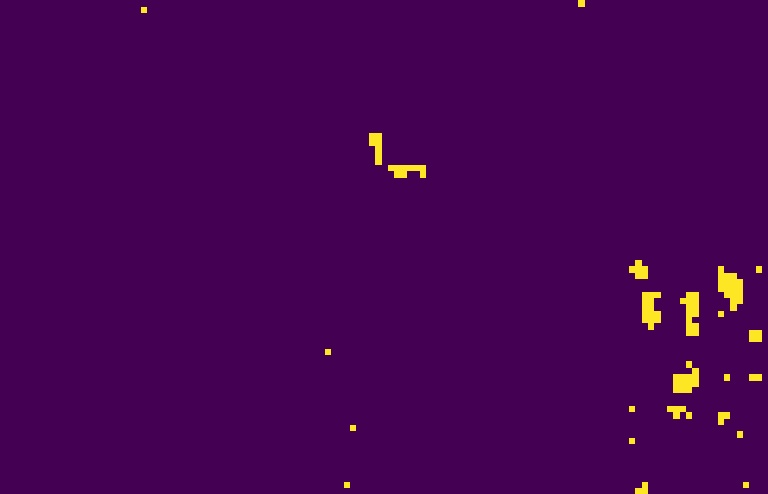

In [9]:
# Input within range (0 in range, 1 out of range)
image_url = (
    output_img.select(['QA']).rightShift(0).bitwiseAnd(1)
    .reproject(crs=landsat_crs, scale=30)
    .getThumbURL({'min': 0, 'max': 1, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
)
Image(url=image_url, embed=True, format='png')

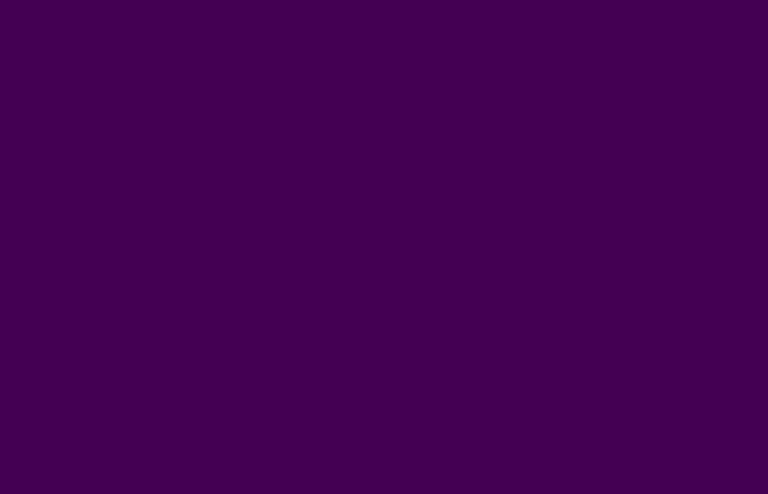

In [10]:
# Output within range (0 in range, 1 out of range)
image_url = (
    output_img.select(['QA']).rightShift(1).bitwiseAnd(1)
    .reproject(crs=landsat_crs, scale=30)
    .getThumbURL({'min': 0, 'max': 8, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
)
Image(url=image_url, embed=True, format='png')

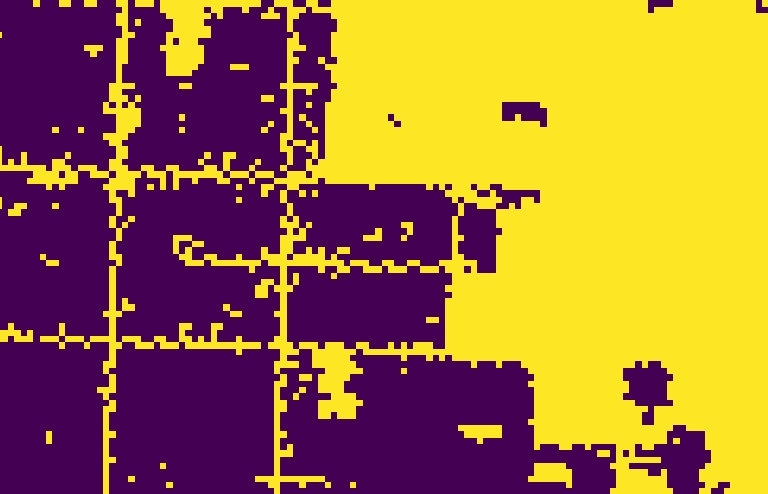

In [12]:
# Biome (0 vegetation, 1 non-vegetation)
image_url = (
    output_img.select(['QA']).rightShift(2).bitwiseAnd(1)
    .reproject(crs=landsat_crs, scale=30)
    .getThumbURL({'min': 0, 'max': 1, 'palette': viridis_palette,
                  'dimensions':image_size, 'region': study_region})
)
Image(url=image_url, embed=True, format='png')

In [ ]:
# def point_image_value(image, xy, scale=30):
#     """Extract the output value from a calculation at a point"""
#     return ee.Image(image).reduceRegion(
#         reducer=ee.Reducer.first(), geometry=ee.Geometry.Point(xy),
#         scale=scale).getInfo()

# test_xy = [-121.1445, 38.7205]
# pprint.pprint(point_image_value(prep_img, test_xy))
# pprint.pprint(point_image_value(
#     prep_img.expression('float((b("nir") - b("red"))) / (b("nir") + b("red"))').rename('ndvi'), 
#     test_xy))
# pprint.pprint(point_image_value(
#     prep_img.normalizedDifference(['nir', 'red']).select(['nd'], ['ndvi']), 
#     test_xy))
# pprint.pprint(point_image_value(output_img.select(['LAI']), test_xy))
